In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, norm

Define parameters of the model.

In [2]:
batch_size = 100
learning_rate = 0.005
lambda_lp = 20 # Gradient penalty
lambda_entropy = 5. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
n_observed = 20000 # Number of observed data
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution 
prop_initial_log_sigma = np.log(.3) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.5
dragan_parameter_C = 0.5
critic_steps_1 = 100
critic_steps_2 = 50
count_steps = 3000+1

#For reproducibility 
tf.set_random_seed(2210)
np.random.seed(2210)

In [3]:
def glorot_uniform(fan_in, fan_out, scale=0.1):
    s = scale * np.sqrt(6. / (fan_in + fan_out))
    return np.random.rand(fan_in, fan_out) * 2 * s - s

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
obs_samples = poisson.rvs(obs_poisson_rate,size=n_observed)

# Define simulator
def simulator(X,epsilon=1e-7):
    return poisson.rvs(np.exp(X))+epsilon

Define AVO model.

In [5]:
batch_shape = (None, 1)
critic_shape = (None, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Placeholder for simulated distribution
X_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Placeholder for proposal shape
proposal_shape = tf.placeholder(tf.int32,shape=[2])

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(), initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=proposal_shape))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 



# Define critic variables
with tf.name_scope('critic'):
    W0 = tf.Variable(glorot_uniform(1,10),dtype=tf.float32,name='W0')
    W1 = tf.Variable(glorot_uniform(10,10),dtype=tf.float32,name='W1')
    W2 = tf.Variable(glorot_uniform(10,1),dtype=tf.float32,name='W2')
    b0 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b0')
    b1 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b1')
    b2 = tf.Variable(np.zeros([1,1]),dtype=tf.float32,name='b2')

# Define the critic
def critic(x):
    h1 = tf.nn.leaky_relu(tf.matmul(x,W0)+b0,alpha=.1)
    h2 = tf.nn.leaky_relu(tf.matmul(h1,W1)+b1,alpha=.1)
    out = tf.matmul(h2,W2)+b2
    return out

# Define perturbed points for LP
X_perturb = tf.concat([X_real,X_sim],axis=0)
u = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=-1.,maxval=1.)
_, batch_std = tf.nn.moments(tf.reshape(X_perturb, [-1]), axes=[0])
delta = dragan_parameter_C * batch_std * u
alpha = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=0.,maxval=1.)
X_perturb += (1. - alpha) * delta

# Compute critic for different inputs sharing the same variables of the NN:
critic_real = critic(X_real)
critic_sim = critic(X_sim)
critic_perturb = critic(X_perturb)

# LP penalty
gradients = tf.gradients(critic_perturb, [X_perturb])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
gradient_penalty = tf.reduce_mean((tf.maximum(0., slopes - 1)) ** 2)

# Define losses
loss_critic = tf.reduce_mean(critic_sim - critic_real)+lambda_lp*gradient_penalty
em = -tf.reduce_mean(critic_sim - critic_real) # Distance between distributions
loss_prop = tf.reduce_mean(-tf.multiply(critic_sim, log_prob_prop) + lambda_entropy*entropy_proposal)

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_b1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_b2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic = [reset_b1,reset_b2,reset_vel_mom]

Run AVO model to find the parameter distribution.

In [6]:
# Save losses
em_v = np.zeros(count_steps)
loss_d = np.zeros(count_steps)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # Output the current values
    mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
    print('Step 0: mu = {}, sigma = {}'.format(mu_val, np.exp(lg_sigma_val)))

    for epoch in range(count_steps):
        # Reset critic optimizer parameters at each epoch
        sess.run(reset_critic)

        # Optimize critic
        #Small batches
        for idx in range(critic_steps_1):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal,feed_dict={proposal_shape:[batch_size,1]})
            x_sim = simulator(thetas)
            _, this_em = sess.run([train_critic, em],feed_dict={X_real:x_real,X_sim:x_sim})
        #Large batches
        x_real = obs_samples.reshape([-1,1])
        thetas = sess.run(sample_proposal,feed_dict={proposal_shape:[n_observed,1]})
        x_sim = simulator(thetas)
        for idx in range(critic_steps_2):
            _, this_em, this_loss_d = sess.run([train_critic, em,loss_critic],
                                               feed_dict={X_real:x_real,X_sim:x_sim})
        # Save loss after optimizing
        em_v[epoch] = this_em
        loss_d[epoch] = this_loss_d

        # Output the current values
        if ((epoch+1) % 10)  == 0:
            mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
            print('Step {}: mu = {}, sigma = {}, em = {}'.format(epoch+1, mu_val, 
                                                                 np.exp(lg_sigma_val), this_em))
        # Update the proposal
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,sample_proposal:thetas})
    
    # Save final values of distribution
    mu_val,lg_sigma_val = sess.run([mu, lg_sigma])

Step 0: mu = 1.6094379425048828, sigma = 0.29999998211860657
Step 10: mu = 1.6544089317321777, sigma = 0.2868003249168396, em = 1.624212622642517
Step 20: mu = 1.7043838500976562, sigma = 0.27281540632247925, em = 1.3212186098098755
Step 30: mu = 1.7543683052062988, sigma = 0.25951114296913147, em = 0.9788221716880798
Step 40: mu = 1.8043532371520996, sigma = 0.24685561656951904, em = 0.7596954107284546
Step 50: mu = 1.854317307472229, sigma = 0.2348175197839737, em = 0.41629937291145325
Step 60: mu = 1.9029375314712524, sigma = 0.22336874902248383, em = 0.3649522364139557
Step 70: mu = 1.9164183139801025, sigma = 0.21247653663158417, em = 0.32113322615623474
Step 80: mu = 1.9235036373138428, sigma = 0.20211473107337952, em = 0.30020684003829956
Step 90: mu = 1.9274979829788208, sigma = 0.1922578066587448, em = 0.2907285690307617
Step 100: mu = 1.92775297164917, sigma = 0.1828816533088684, em = 0.2468637228012085
Step 110: mu = 1.933557391166687, sigma = 0.1739625334739685, em = 0.1912

Step 930: mu = 1.94922935962677, sigma = 0.00288533978164196, em = 0.025434015318751335
Step 940: mu = 1.947633147239685, sigma = 0.0027446576859802008, em = 0.020041339099407196
Step 950: mu = 1.9361306428909302, sigma = 0.0026108906604349613, em = 0.04838135838508606
Step 960: mu = 1.9394861459732056, sigma = 0.0024835781659930944, em = 0.03052106313407421
Step 970: mu = 1.960314154624939, sigma = 0.002362459897994995, em = 0.07360692322254181
Step 980: mu = 1.9530237913131714, sigma = 0.0022472389973700047, em = 0.07456182688474655
Step 990: mu = 1.9354249238967896, sigma = 0.002137640258297324, em = 0.06056079640984535
Step 1000: mu = 1.9203574657440186, sigma = 0.0020333928987383842, em = 0.1869249939918518
Step 1010: mu = 1.920759677886963, sigma = 0.0019342430168762803, em = 0.1770557165145874
Step 1020: mu = 1.9410593509674072, sigma = 0.0018399216933175921, em = 0.008062927983701229
Step 1030: mu = 1.943558931350708, sigma = 0.001750194001942873, em = 0.017816787585616112
Step

Step 1830: mu = 1.8422318696975708, sigma = 3.210280556231737e-05, em = 0.6985138058662415
Step 1840: mu = 1.8214654922485352, sigma = 3.0537274142261595e-05, em = 0.8244353532791138
Step 1850: mu = 1.8380070924758911, sigma = 2.9048002033960074e-05, em = 0.7221789956092834
Step 1860: mu = 1.8702430725097656, sigma = 2.7631334887701087e-05, em = 0.5130079388618469
Step 1870: mu = 1.8941190242767334, sigma = 2.628380934766028e-05, em = 0.36114317178726196
Step 1880: mu = 1.90000581741333, sigma = 2.500197479093913e-05, em = 0.31078627705574036
Step 1890: mu = 1.9120993614196777, sigma = 2.3782815333106555e-05, em = 0.22809624671936035
Step 1900: mu = 1.9201349020004272, sigma = 2.262297311972361e-05, em = 0.16505703330039978
Step 1910: mu = 1.9236652851104736, sigma = 2.151971602870617e-05, em = 0.1393083930015564
Step 1920: mu = 1.8989723920822144, sigma = 2.0470301024033688e-05, em = 0.3359898328781128
Step 1930: mu = 1.8894858360290527, sigma = 1.9472041458357126e-05, em = 0.39912810

Step 2740: mu = 1.7182356119155884, sigma = 3.393080305613694e-07, em = 1.4675185680389404
Step 2750: mu = 1.7275607585906982, sigma = 3.227597176191921e-07, em = 1.426438570022583
Step 2760: mu = 1.7327631711959839, sigma = 3.070187801768043e-07, em = 1.4051599502563477
Step 2770: mu = 1.7112243175506592, sigma = 2.920449446719431e-07, em = 1.4966915845870972
Step 2780: mu = 1.6988000869750977, sigma = 2.7780248501585447e-07, em = 1.5936566591262817
Step 2790: mu = 1.6948332786560059, sigma = 2.6425411192576576e-07, em = 1.6203460693359375
Step 2800: mu = 1.7136024236679077, sigma = 2.513662309411302e-07, em = 1.4788585901260376
Step 2810: mu = 1.7170742750167847, sigma = 2.3910783397695923e-07, em = 1.4711474180221558
Step 2820: mu = 1.7113991975784302, sigma = 2.2744657712792105e-07, em = 1.5043445825576782
Step 2830: mu = 1.7034696340560913, sigma = 2.1635423763655126e-07, em = 1.5694646835327148
Step 2840: mu = 1.6845571994781494, sigma = 2.0580247905854776e-07, em = 1.65990114212

Plot result:

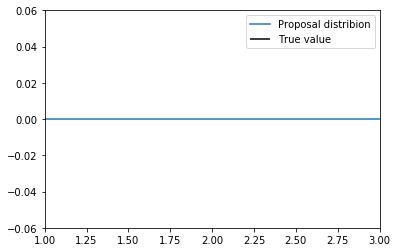

In [7]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val,np.exp(lg_sigma_val))

plt.plot(x,y,label="Proposal distribion")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()

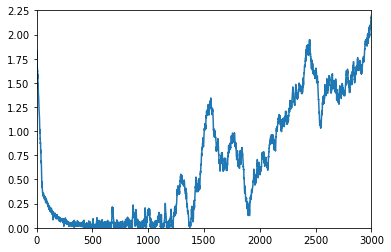

In [8]:
plt.plot(em_v)

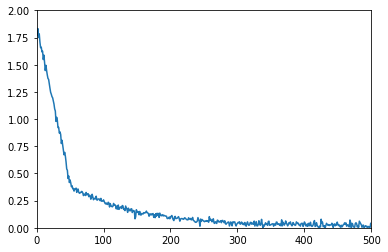

In [13]:
plt.plot(em_v[:500])

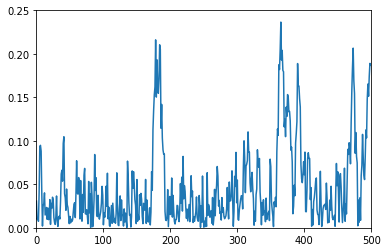

In [12]:
plt.plot(em_v[500:1000])

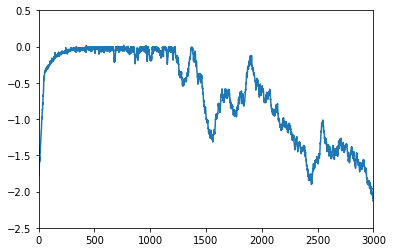

In [10]:
plt.plot(loss_d)

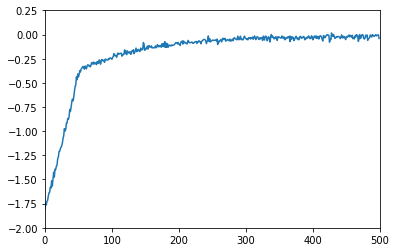

In [14]:
plt.plot(loss_d[:500])

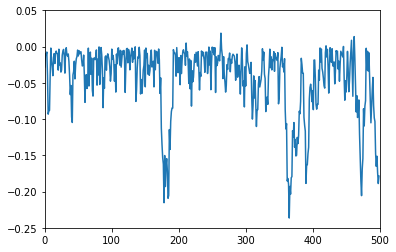

In [15]:
plt.plot(loss_d[500:1000])